In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Bayesian POLIMI

Mounted at /gdrive
/gdrive/My Drive/Bayesian POLIMI


In [ ]:
# Install cmdstanpy module
!pip install cmdstanpy

!pip list | grep cmdstanpy


cmdstanpy                          1.2.5


In [ ]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [ ]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmps3fzlia6
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [ ]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [ ]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [ ]:
y = pd.read_csv('TremorProb_1.csv')
print(y.head())

   -0.620922462937449  -0.668689165888089  -0.409872821087173  \
0           -0.620922           -0.668689           -0.409873   
1           -0.620922           -0.668689           -0.409873   
2           -0.620922           -0.668689           -0.409873   
3           -0.620922           -0.668689           -0.409873   
4           -0.620922           -0.668689           -0.409873   

   -0.46836544467914  -0.672098617117627  -0.568842619576277  \
0          -0.468365           -0.672099           -0.568843   
1          -0.468365           -0.672099           -0.568843   
2          -0.468365           -0.672099           -0.568843   
3          -0.468365           -0.672099           -0.568843   
4          -0.468365           -0.672099           -0.568843   

   -0.478079682575386  -0.417804016451204  -0.758451513461839  \
0            -0.47808           -0.417804           -0.758452   
1            -0.47808           -0.417804           -0.758452   
2            -0.47808        

In [ ]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 15


In [ ]:
x = np.linspace(0,1,N)

In [ ]:
y = np.array(np.transpose(y))

In [ ]:
y

array([[-0.62092246, -0.66868917, -0.40987282, ..., -0.4982822 ,
        -0.6061394 , -0.42226794],
       [-0.62092246, -0.66868917, -0.40987282, ..., -0.4982822 ,
        -0.6061394 , -0.42226794],
       [-0.62092246, -0.66868917, -0.40987282, ..., -0.4982822 ,
        -0.6061394 , -0.42226794],
       ...,
       [-0.62092246,  0.59905107, -0.31308653, ..., -0.4982822 ,
        -0.3327095 , -0.42226794],
       [-0.62092246,  0.25255206, -0.35717438, ..., -0.4982822 ,
        -0.43775713, -0.42226794],
       [-0.62092246,  0.12731979, -0.40126223, ..., -0.4982822 ,
        -0.59682581, -0.42226794]])

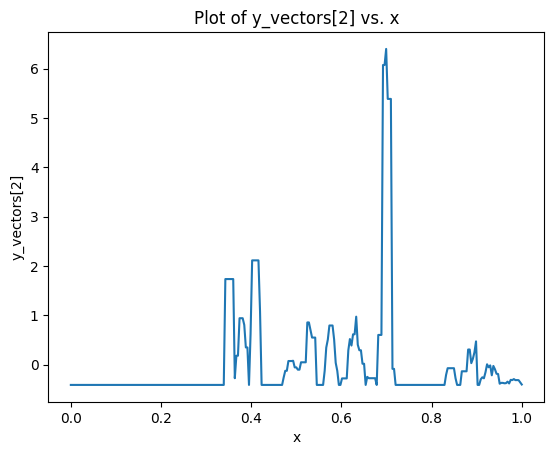

In [ ]:
plt.plot(x, y[:,2])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
   \mathbf{y}{t}(s) = (1-\beta) \mu(s) + \beta \mathbf{y}{t-1}+ ϵ \in \mathbb{R}^{N}
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((1-\beta) \mu + \beta \mathbf{y}_{t-1}, diag(\tau^2))\\
    \mu &\sim \text{multivariate normal}(0,\sigma^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau_i &\overset{\underset{\mathrm{i.i.d}}{}}{\sim} \text{InvGamma}(1, 2)  \    i=1,2...,N\\
    \beta &\sim \text{Beta}(1.5,1.5)
\end{aligned}

And
\begin{aligned}
 \mathbf{A}(\rho)_{ij} &= \frac{1}{(1-\rho^2)} \rho^{\lvert i-j \rvert}
 \end{aligned}

In [ ]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [ ]:
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoreggresive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = rep_vector(0,N);
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          real<lower=0> beta;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
          beta ~ beta(1.5,1.5);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

08:08:14 - cmdstanpy - INFO - compiling stan file /tmp/tmp2puuhwlu/tmp27qcuvek.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /tmp/tmp2puuhwlu/tmp27qcuvek.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/MyDrive/Bayesian\ POLIMI/stan /tmp/tmp2puuhwlu/tmp27qcuvek
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/gdrive/MyDrive/Bayesian\ POLIMI/stan --o=/tmp/tmp2puuhwlu/tmp27qcuvek.hpp /tmp/tmp2puuhwlu/tmp27qcuvek.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/sta

In [ ]:
y.shape

(15, 287)

In [ ]:
y0 = y[:,0] + np.random.normal(0,0.1,N)

In [ ]:
y0.shape

(287,)

In [ ]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "rho": 0.3
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1bslecak/_9oui8c3.json
08:58:01 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML', 'id=1', 'random', 'seed=90713', 'data', 'file=/tmp/tmp1bslecak/_9oui8c3.json', 'output', 'file=/tmp/tmp1bslecak/synt5GP_fitML0xjol1up/synt5GP_fitML-20241219085801_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML', 'id=3', 'random', 'seed=90713', 'data', 'file=/tmp/tmp1bslecak/_9oui8c3.json', 'output', 'file=/tmp/tmp1bslecak/synt5GP_fitML0xjol1up/synt5GP_fitML-20241219085801_3.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML', 'id=2

09:22:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Bayesian POLIMI/stan/synt5GP_fitML', 'id=1', 'random', 'seed=90713', 'data', 'file=/tmp/tmp1bslecak/_9oui8c3.json', 'output', 'file=/tmp/tmp1bslecak/synt5GP_fitML0xjol1up/synt5GP_fitML-20241219085801_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1bslecak/synt5GP_fitML0xjol1up/synt5GP_fitML-20241219085801_1.csv
 console_msgs (if any):
	/tmp/tmp1bslecak/synt5GP_fitML0xjol1up/synt5GP_fitML-20241219085801_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
    

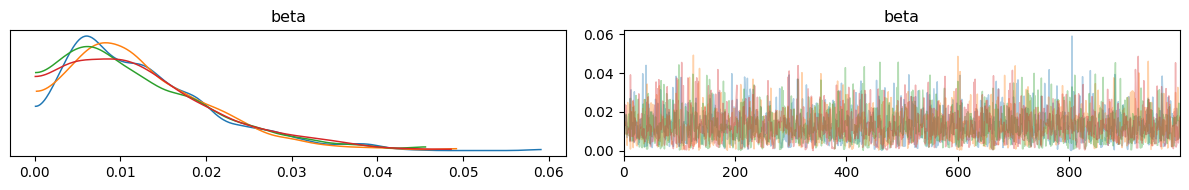

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
plt.tight_layout()
plt.show()

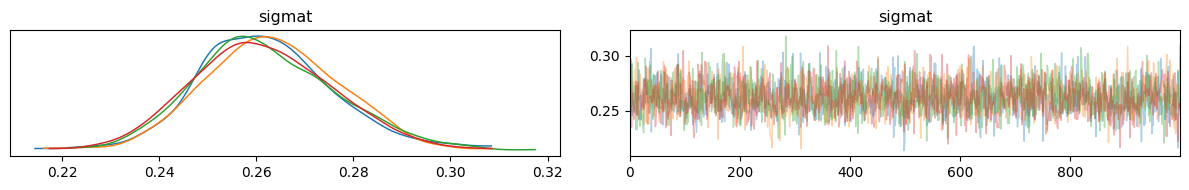

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


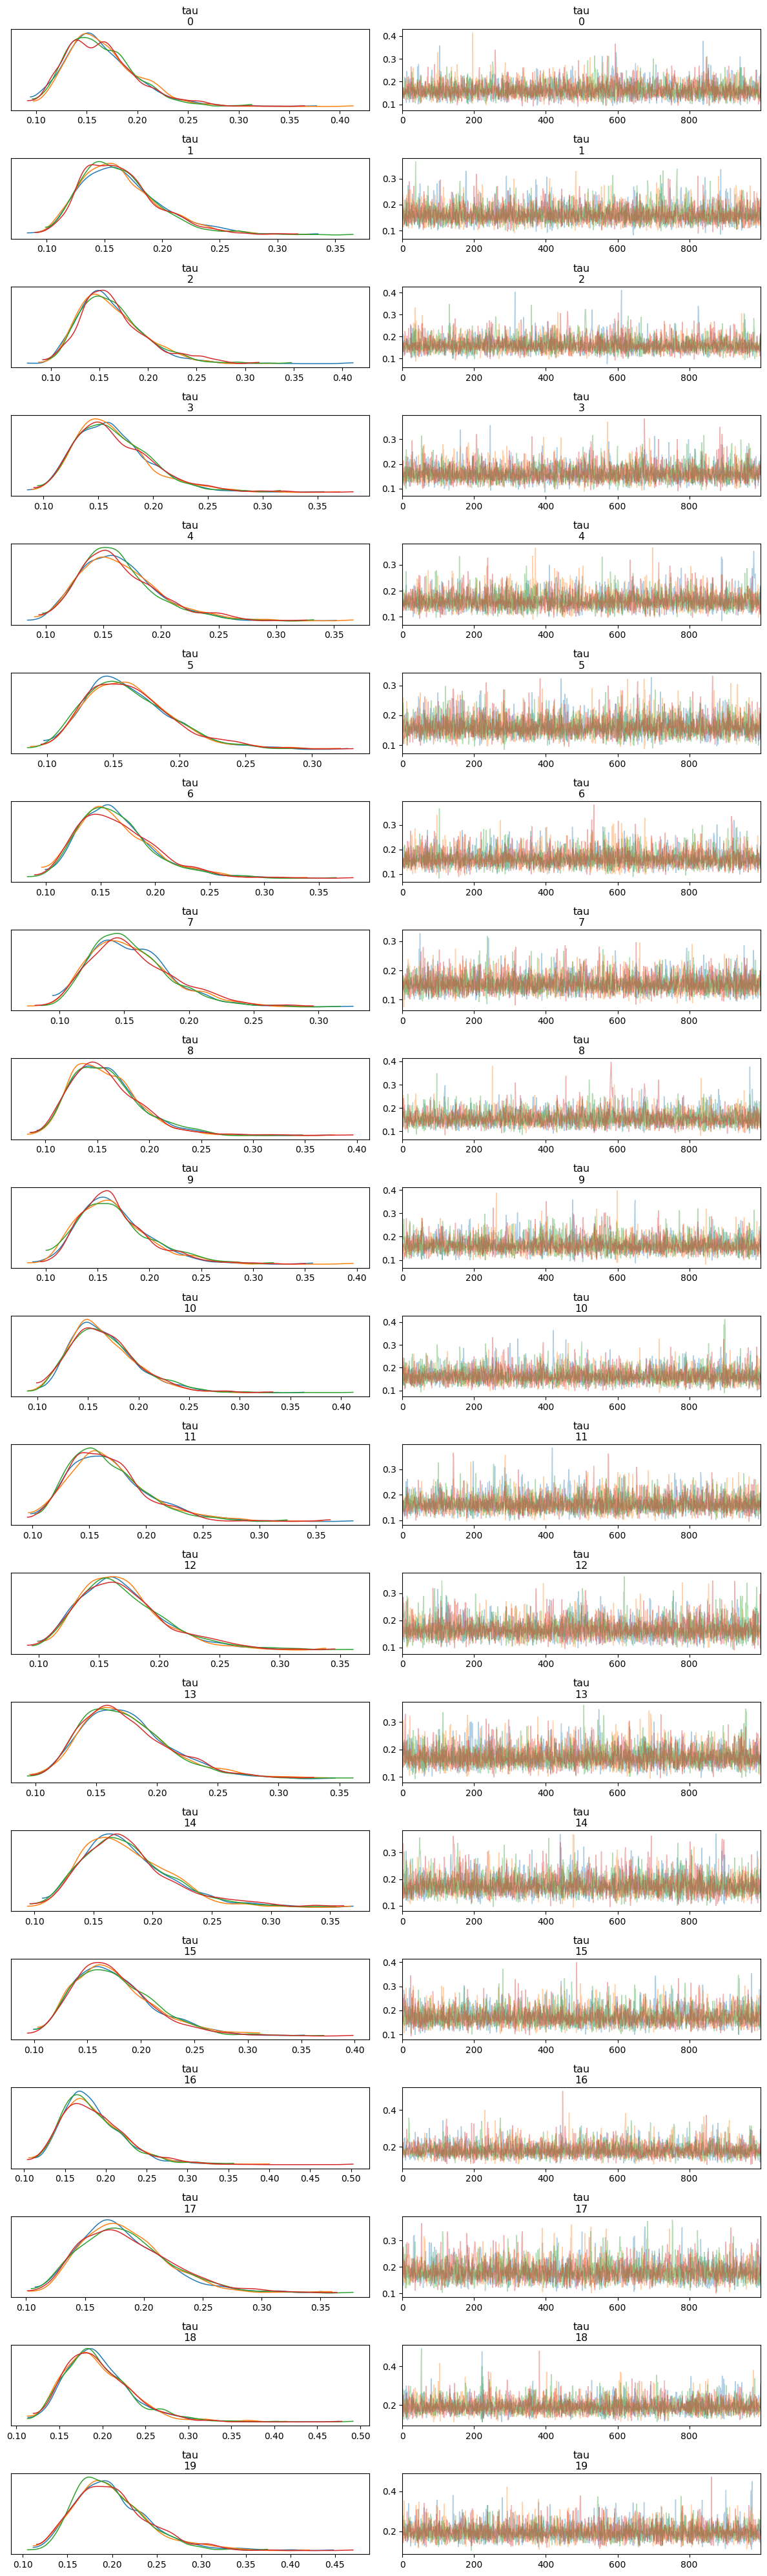

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['tau'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


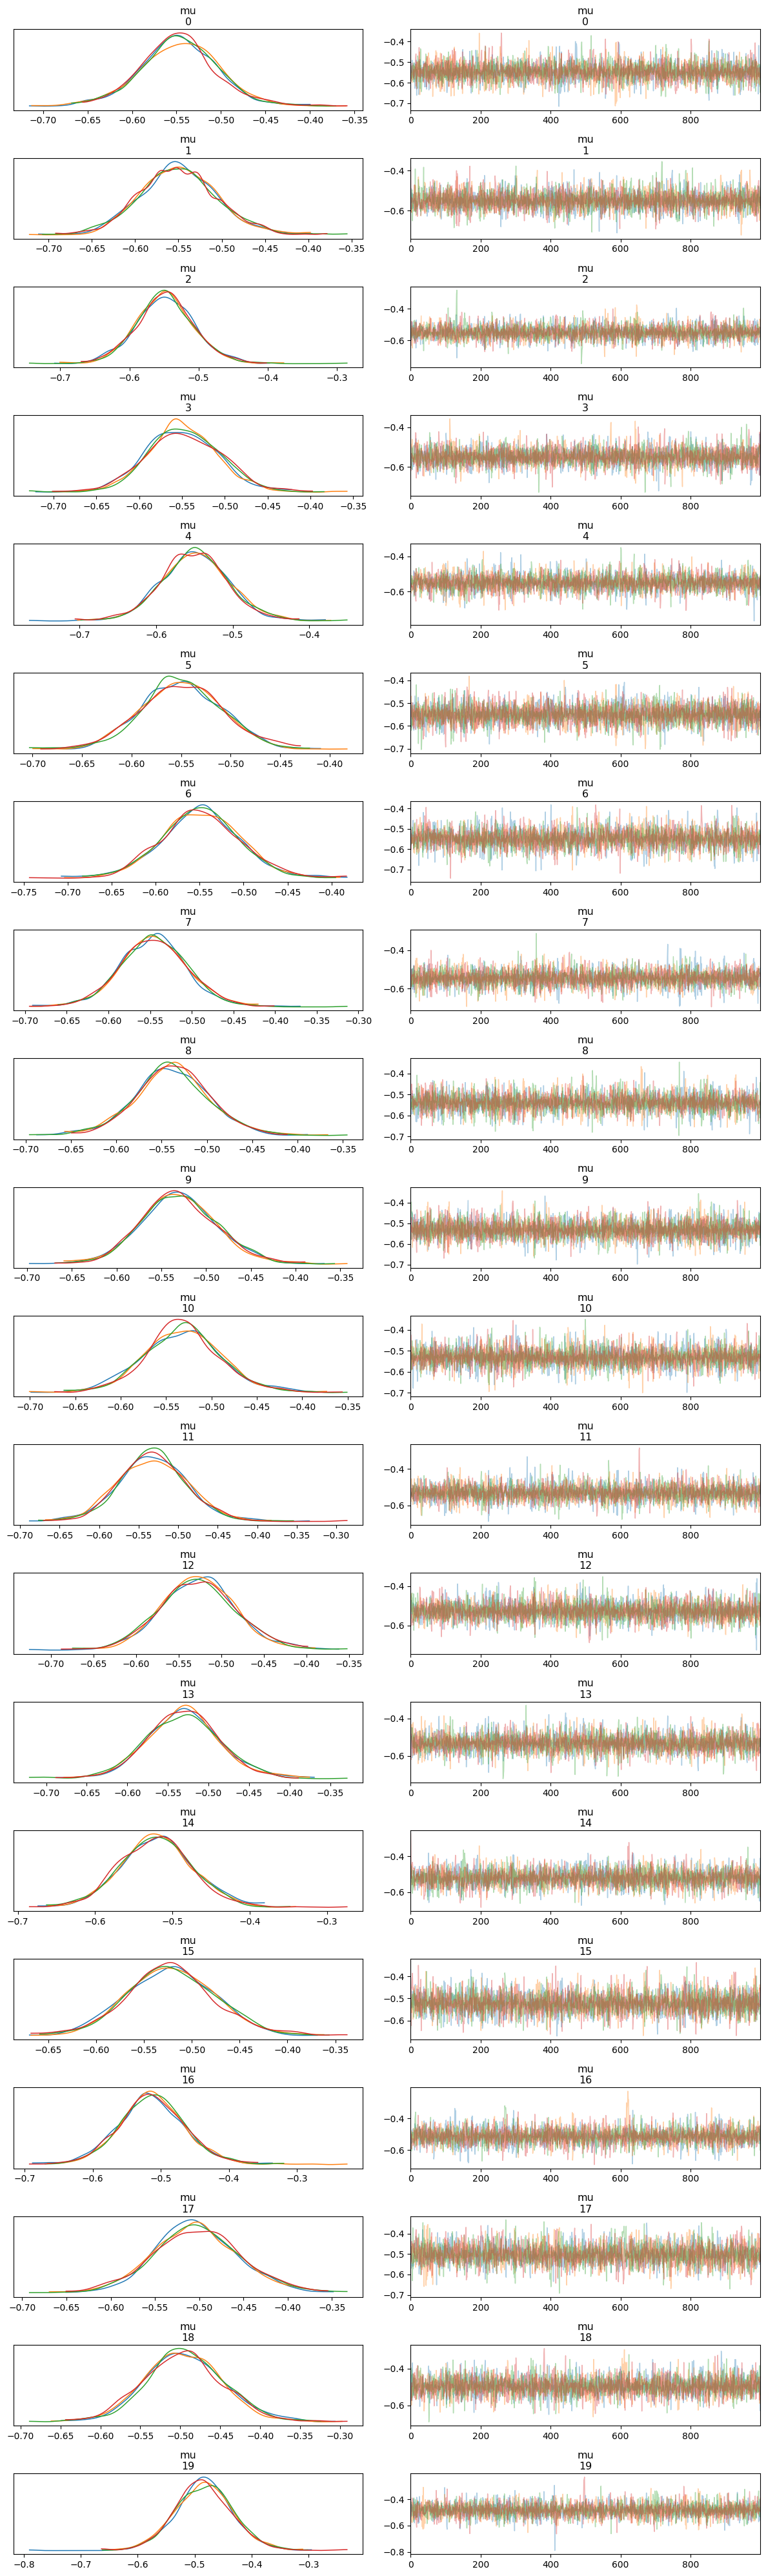

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
betas = cmdstanpy_data['posterior']['beta'][3]
taus = cmdstanpy_data['posterior']['tau'][3]
mus = cmdstanpy_data['posterior']['mu'][3]
#sigmas = cmdstanpy_data['posterior']['sigma'][3]
beta = betas.mean().item() # convert to float
tau = taus.mean().item() # convert to float
mu = mus.mean().item() # convert to float
#sigma = sigmas.mean().item() # convert to float

In [ ]:
mu = np.mean(mus, axis=0)

In [ ]:
mu

<xarray.DataArray 'mu' (mu_dim_0: 287)> Size: 2kB
array([-0.54685822, -0.55001922, -0.54774429, -0.54751192, -0.55202612,
       -0.54880818, -0.54778542, -0.54543647, -0.5364556 , -0.53041097,
       -0.53125684, -0.53089368, -0.52707494, -0.53177019, -0.52163278,
       -0.52167479, -0.51308715, -0.50223799, -0.496991  , -0.48525515,
       -0.47114646, -0.42223533, -0.39492808, -0.39957238, -0.41152662,
       -0.42477981, -0.44187927, -0.46672912, -0.46167311, -0.43583661,
       -0.42362081, -0.42727205, -0.42428714, -0.43969041, -0.47566414,
       -0.49690956, -0.49153757, -0.47514504, -0.46834697, -0.47764152,
       -0.4769297 , -0.48530433, -0.48462331, -0.49941922, -0.50268656,
       -0.49896926, -0.48858169, -0.4832515 , -0.44654369, -0.42896719,
       -0.41798646, -0.43074743, -0.44856411, -0.44349001, -0.48406597,
       -0.4235421 , -0.40489695, -0.39654925, -0.35131635, -0.34738699,
       -0.37913929, -0.45815146, -0.48361434, -0.45490151, -0.48377196,
       -0.46621773, -0.34246276, -0.27476284, -0.22104717, -0.19080991,
       -0.17017554, -0.17607922, -0.23505749, -0.22353942, -0.17841435,
       -0.1908075 , -0.16377293, -0.11355373, -0.05750753, -0.00754595,
       -0.0056514 , -0.0167621 , -0.06096658, -0.19030942, -0.27325811,
       -0.30516427, -0.2520637 , -0.20460824, -0.11091748, -0.05200414,
        0.01016147,  0.06618454,  0.10482658,  0.17373704,  0.20410814,
        0.21754944,  0.22925526,  0.25085818,  0.26569893,  0.21100109,
...
        0.03219131,  0.14364804,  0.20243807,  0.34012535,  0.38374815,
        0.41387289,  0.37624489,  0.34946789,  0.32521814,  0.26775356,
        0.24215759,  0.23061282,  0.24377548,  0.19217457,  0.07342696,
        0.02859214,  0.00785281, -0.08817111, -0.28056952, -0.10397486,
       -0.00091353,  0.05951186,  0.06567316,  0.04788067,  0.12130114,
        0.09722324,  0.09514407,  0.0889632 ,  0.05573635,  0.16675402,
        0.21359699,  0.2630846 ,  0.2669743 ,  0.28284465,  0.28234222,
        0.22498493,  0.15086321,  0.05862262,  0.09303549,  0.11988504,
        0.21505283,  0.2513897 ,  0.27456869,  0.31749753,  0.33741107,
        0.34801992,  0.35182363,  0.34874955,  0.34966994,  0.3233587 ,
        0.18337258,  0.03937238, -0.03416207, -0.0632331 ,  0.03556981,
        0.08101923,  0.16097194,  0.19031711,  0.18727472,  0.18096579,
        0.11522786,  0.01741587, -0.01657372, -0.04835733, -0.11759769,
       -0.10728746, -0.05729609,  0.08708589,  0.11347441,  0.17648318,
        0.19000936,  0.157329  ,  0.14848985,  0.04765935, -0.01950526,
       -0.13637234, -0.17859166, -0.28272209, -0.25972052, -0.22704937,
       -0.20061508, -0.17254994, -0.22347215, -0.24895358, -0.23801855,
       -0.27673072, -0.30414546, -0.37743772, -0.3376851 , -0.29069669,
       -0.24425802, -0.2316732 , -0.24437848, -0.27996565, -0.31028069,
       -0.33641918, -0.41558273])
Coordinates:
    chain     int64 8B 3
  * mu_dim_0  (mu_dim_0) int64 2kB 0 1 2 3 4 5 6 ... 280 281 282 283 284 285 286

In [ ]:
y_sim = beta*y[12,:] + (1-beta)*mu

In [ ]:
tau = np.mean(taus, axis=0)
K = np.diag(tau)

In [ ]:
y_draws = np.random.multivariate_normal(y_sim, K, 500)

In [ ]:
y_new = np.mean(y_draws, axis=0)

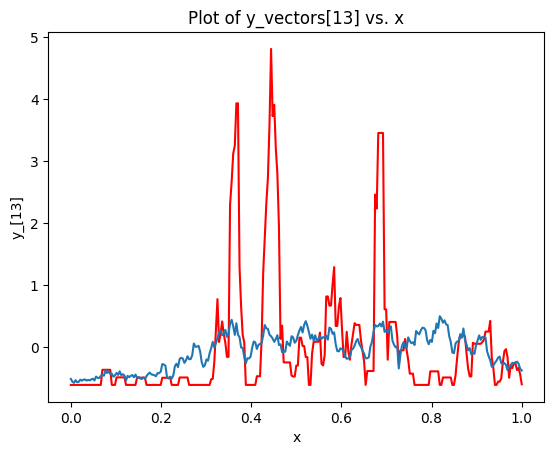

In [ ]:
plt.plot(x, y[13,:], color="red")
plt.plot(x, y_new)
plt.xlabel("x")
plt.ylabel("y_[13]")
plt.title("Plot of y_vectors[13] vs. x")
plt.show()

Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)